# Reproduce Figure 1
2D adversarial spheres propagated in deep batch-normalized linear network at init

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data

from sklearn.decomposition import PCA

In [2]:
N = 32  # N is the mini-batch size
seed = 3
N_CLASSES = 2

np.random.seed(seed)

theta = np.linspace(0, 2 * np.pi, N + 1)

xCenter = 0
yCenter = 0
radius = 1;

x = radius * np.cos(theta) + xCenter;
y = radius * np.sin(theta) + yCenter;

# Training set
train_x = np.zeros((2 * N, 2)) # DATA, FEATURES
train_y = np.zeros(2 * N)      # DATA, Int label

# class 1
train_x[:N, 0] = x[:N].copy() #+ np.random.randn(N) / 30
train_x[:N, 1] = y[:N].copy() #+ np.random.randn(N) / 30
train_y[:N] = 0

# class 2
train_x[N:, 0] = x[:N].copy() * 1.3 #+ np.random.randn(N) / 30
train_x[N:, 1] = y[:N].copy() * 1.3 #+ np.random.randn(N) / 30
train_y[N:] = 1

is_shuffled = False

In [3]:
rng_state = np.random.get_state()
np.random.shuffle(train_x)
np.random.set_state(rng_state)
np.random.shuffle(train_y)
is_shuffled = True

In [4]:
colors_txt = ['red', 'blue']

In [5]:
R_rgba = mpl.colors.to_rgba('red', alpha=1.)
B_rgba = mpl.colors.to_rgba('blue', alpha=1.)

In [6]:
train_y = train_y.astype('int')

In [7]:
colors = np.random.random((2 * N, 4))
for i in range(2 * N):
    if train_y[i]:
        colors[i] = B_rgba
    else:
        colors[i] = R_rgba

Visualize dataset

Text(0.5, 1.0, 'Layer 0')

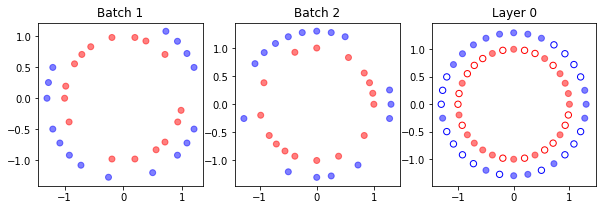

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

colors_txt = ['red', 'blue']
ax1.scatter(train_x[:N, 0], train_x[:N, 1], c=train_y[:N], alpha=0.5, 
            cmap=mpl.colors.ListedColormap(colors_txt))
ax1.set_title("Batch 1")

ax2.scatter(train_x[N:, 0], train_x[N:, 1], c=train_y[N:], alpha=0.5, 
            cmap=mpl.colors.ListedColormap(colors_txt))
ax2.set_title("Batch 2")

ax3.scatter(train_x[:N, 0], train_x[:N, 1], edgecolors=colors, c='w', s=40)
ax3.scatter(train_x[N:, 0], train_x[N:, 1], c=train_y[N:], alpha=0.5, cmap=mpl.colors.ListedColormap(colors_txt))

ax3.set_title("Layer 0")

#fig.savefig('AdversarialSpheres.png')

In [9]:
print("Batch 1")
print(np.mean(train_x[:N]))
print(np.std(train_x[:N]))

print("Batch 2")
print(np.mean(train_x[N:]))
print(np.std(train_x[N:]))

Batch 1
-0.054928393483348145
0.8182193297578215
Batch 2
0.05492839348334812
0.8182193297578214


In [10]:
torch.manual_seed(seed)

In [11]:
X_train = torch.tensor(train_x, dtype=torch.float)
Y_train = torch.tensor(train_y, dtype=torch.long)

# create datasets
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader_noshuffle = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=N, shuffle=False)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)

In [12]:
activations = []
def hook(module, input, output):
    activations.append(output)

In [13]:
class LinearNetwork(nn.Module):
    def __init__(self, input_size, num_layers, num_units, num_classes, do_batch_norm=False):
        super(LinearNetwork, self).__init__()
        self.do_batch_norm = do_batch_norm
        self.input_layer = nn.Linear(input_size, num_units, bias=True)
        self.features = self._make_layers(num_layers, num_units)
        self.classifier = nn.Linear(num_units, num_classes, bias=True)

    def forward(self, inputs):
        """Forward pass, returns outputs of each layer. Use last out (final) for backprop!"""
        out = self.input_layer(inputs)
        out = self.features(out)
        out = self.classifier(out)
        return out
    
    def _make_layers(self, num_layers, num_units):
        layers = []
        for i in range(num_layers):
            if self.do_batch_norm:
                layers += [nn.BatchNorm1d(num_units, momentum=None),
                           nn.Linear(num_units, num_units, bias=True)]
            else:
                layers += [nn.Linear(num_units, num_units, bias=True)]
        return nn.Sequential(*layers)

In [14]:
num_units = 10
num_layers = 30
do_batch_norm = True
device = torch.device('cpu')
#device = torch.device('cuda:0')
model = LinearNetwork(train_x.shape[1], num_layers, num_units, N_CLASSES, do_batch_norm=do_batch_norm).to(device)

In [15]:
activations=[]
with torch.no_grad():
    for inputs, labels in train_loader_noshuffle:
        inputs = inputs.to(device)
        labels = labels.to(device)
        out = model(inputs)
        break
print(len(activations))

0


In [16]:
j = 0
L = num_layers * 2 # ReLUNetwork
register_idx = 1

for i in range(L):
    if i == register_idx:
        j += 1
        register_idx += 2
        print('%d %s' % (j, model.features[i]))
        model.features[i].register_forward_hook(hook)

1 Linear(in_features=10, out_features=10, bias=True)
2 Linear(in_features=10, out_features=10, bias=True)
3 Linear(in_features=10, out_features=10, bias=True)
4 Linear(in_features=10, out_features=10, bias=True)
5 Linear(in_features=10, out_features=10, bias=True)
6 Linear(in_features=10, out_features=10, bias=True)
7 Linear(in_features=10, out_features=10, bias=True)
8 Linear(in_features=10, out_features=10, bias=True)
9 Linear(in_features=10, out_features=10, bias=True)
10 Linear(in_features=10, out_features=10, bias=True)
11 Linear(in_features=10, out_features=10, bias=True)
12 Linear(in_features=10, out_features=10, bias=True)
13 Linear(in_features=10, out_features=10, bias=True)
14 Linear(in_features=10, out_features=10, bias=True)
15 Linear(in_features=10, out_features=10, bias=True)
16 Linear(in_features=10, out_features=10, bias=True)
17 Linear(in_features=10, out_features=10, bias=True)
18 Linear(in_features=10, out_features=10, bias=True)
19 Linear(in_features=10, out_feature

In [17]:
activations = []

#model.train() #
model.eval()

for i, (inputs, labels) in enumerate(train_loader_noshuffle):
    inputs = inputs.to(device)
    labels = labels.to(device)
    if i == 0:
        x_b0 = inputs.detach().cpu().numpy()
        y_b0 = labels.detach().cpu().numpy()
        pred = model(inputs)
    elif i == 1:
        x_b1 = inputs.detach().cpu().numpy()
        y_b1 = labels.detach().cpu().numpy()
        pred = model(inputs)
    else:
        break        
print(len(activations))

60


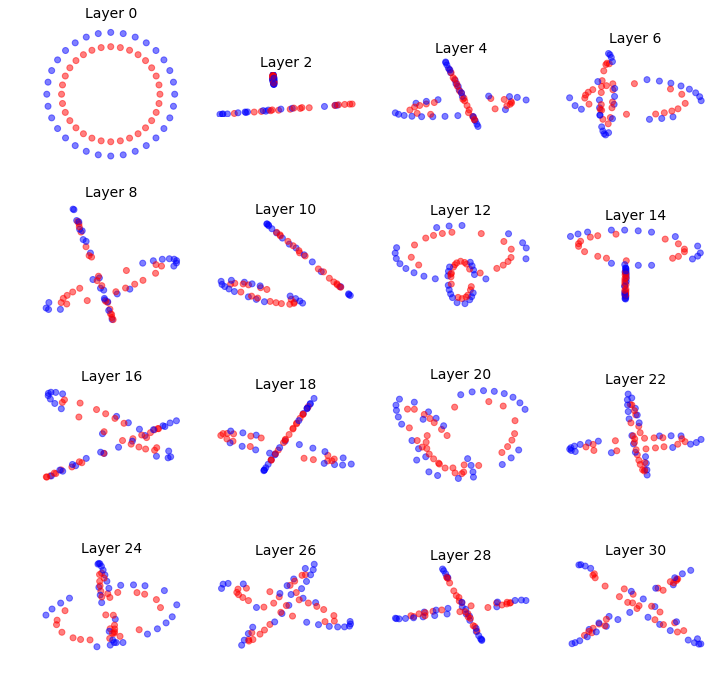

In [18]:
# concatenate x and y for two mini-batches
x_batch = np.concatenate((x_b0, x_b1))
y_batch = np.concatenate((y_b0, y_b1)) 

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
ax = axes.ravel().tolist()

if is_shuffled:
    ax[0].scatter(x_batch[:N, 0], x_batch[:N, 1], c=train_y[:N], alpha=0.5, cmap=mpl.colors.ListedColormap(colors))
    ax[0].scatter(x_batch[N:, 0], x_batch[N:, 1], c=train_y[N:], alpha=0.5, cmap=mpl.colors.ListedColormap(colors))
else:
    ax[0].scatter(x_batch[:N, 0], x_batch[:N, 1], c='r', alpha=0.5)
    ax[0].scatter(x_batch[N:, 0], x_batch[N:, 1], c='b', alpha=0.5)

ax[0].set_title("Layer 0", fontsize=14)
ax[0].axis('off')

layers = num_layers - 1
layer_nb = 2

#correlation_arr = np.zeros(layers)

j = 1
for i in range(layers): # loop over rows
    a = activations[i].detach().cpu().numpy() # batch 0 
    b = activations[i + layers].detach().cpu().numpy() # batch 1
    ab = np.concatenate((a, b))
    pca = PCA(n_components=2)
    pca.fit(ab)
    ab_pca = np.dot(pca.components_, ab.T).T # project activations onto top-2 components
    '''
    correlation_arr[i] = (np.abs(np.corrcoef(ab_pca[:N, 0], ab_pca[N:, 0])[0][1]) + \
                          np.abs(np.corrcoef(ab_pca[:N, 1], ab_pca[N:, 1])[0][1])) / 2
    '''
    if i % 2 == 0 and j < 16:
        if is_shuffled:
            ax[j].scatter(ab_pca[:N, 0], ab_pca[:N, 1], c=train_y[:N], alpha=0.5, cmap=mpl.colors.ListedColormap(colors))
            ax[j].scatter(ab_pca[N:, 0], ab_pca[N:, 1], c=train_y[N:], alpha=0.5, cmap=mpl.colors.ListedColormap(colors))
        else:
            ax[j].scatter(ab_pca[:N, 0], ab_pca[:N, 1], c='r', alpha=0.5)
            ax[j].scatter(ab_pca[N:, 0], ab_pca[N:, 1], c='b', alpha=0.5)
        ax[j].set_title("Layer %d" % layer_nb, fontsize=14)
        ax[j].set_aspect('equal', 'box')
        ax[j].axis('off')
        layer_nb += 2
        j += 1

In [19]:
init = 'He'
mode = 'Train' if model.training else 'Eval'
CKPT_NAME = 'AdvSpheresNoNoiseNoShuffle_ReLUNet_Init%s_L%d_W%d_BN%s_Mode%s_Seed%d_MB%d.png' % (init, num_layers, num_units, do_batch_norm, mode, seed, N)
print(CKPT_NAME)
#fig.savefig(os.path.join('./img', CKPT_NAME))

AdvSpheresNoNoiseNoShuffle_ReLUNet_InitHe_L30_W10_BNTrue_ModeEval_Seed3_MB32.png


In [20]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Figure 1

You may get slightly different results than our Figure 1 due to differences in random initialization.

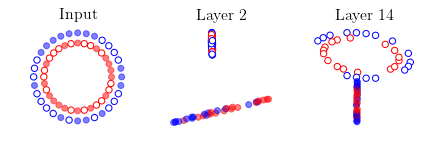

In [21]:
radii=40
fontsz=16
fig, axes = plt.subplots(1, 3, figsize=(6, 2.2))#, sharex=True, sharey=True)

ax = axes.ravel().tolist()

if is_shuffled:
    ax[0].scatter(x_batch[:N, 0], x_batch[:N, 1], edgecolors=colors, c='w', s=radii)
    ax[0].scatter(x_batch[N:, 0], x_batch[N:, 1], c=train_y[N:], alpha=0.5, cmap=mpl.colors.ListedColormap(colors))
    ax[0].set_title("Input", fontsize=fontsz)
    ax[0].set_aspect('equal', 'box')
    ax[0].axis('off')

layers = num_layers - 1
layer_nb = 2

j = 1
for i in range(layers): # loop over rows
    a = activations[i].detach().cpu().numpy() # batch 0 
    b = activations[i + layers].detach().cpu().numpy() # batch 1
    ab = np.concatenate((a, b))
    pca = PCA(n_components=2)
    pca.fit(ab)
    ab_pca = np.dot(pca.components_, ab.T).T # project activations onto top-2 components
    if i % 2 == 0:
        if j == 1:
            ax[1].scatter(ab_pca[:N, 0], ab_pca[:N, 1], edgecolors=colors, c='w', s=radii)
            ax[1].scatter(ab_pca[N:, 0], ab_pca[N:, 1], c=train_y[N:], alpha=0.5, cmap=mpl.colors.ListedColormap(colors))
            ax[1].set_title("Layer %d" % layer_nb, fontsize=fontsz)
            #ax[1].set_aspect('equal', 'box')
            ax[1].axis('off')
        if j == 7:
            ax[2].scatter(ab_pca[:N, 0], ab_pca[:N, 1], edgecolors=colors, c='w', s=radii)
            ax[2].scatter(ab_pca[N:, 0], ab_pca[N:, 1], c=train_y[N:], alpha=0.5, cmap=mpl.colors.ListedColormap(colors))
            ax[2].set_title("Layer %d" % layer_nb, fontsize=fontsz)
            #ax[2].set_aspect('equal', 'box')
            ax[2].axis('off')
        layer_nb += 2
        j += 1    
plt.tight_layout()
plt.show()

In [22]:
init = 'He'
mode = 'Train' if model.training else 'Eval'
CKPT_NAME = 'AdvSpheresNoNoise3x_LinearNet_Init%s_L%d_W%d_BN%s_Mode%s_Seed%d_MB%d_EdgeColorsBatch.png' % (init, num_layers, num_units, do_batch_norm, mode, seed, N)
print(CKPT_NAME)
#fig.savefig(os.path.join('./img', CKPT_NAME))

AdvSpheresNoNoise3x_LinearNet_InitHe_L30_W10_BNTrue_ModeEval_Seed3_MB32_EdgeColorsBatch.png
